# Exploratory Data Analysis
## Importing Necessary Libraries

In [429]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

## Reading Data
In order to identify data at once, the file name and file content were created as **key value pairs** and kept in *dictionary format*.

In [ ]:
sns.set_style('whitegrid')
%matplotlib inline
# assign path
path, dirs, files = next(os.walk("./points"))
file_count = len(files)
dataframes_list = []
 
# append datasets to the list
for i in range(file_count):
    temp_df = pd.read_csv("./points/"+files[i])
    dataframes_list.append({'{}'.format(files[i]):temp_df})

## Function Definitions 

In [430]:
#necessary functions to handle data
def deleteUnwanted(frame, col):
    if not frame[col].empty:
        frame = frame.drop([col], axis=1)
        return frame
    
#get point_name and frame    
def findCSVName(frame):
    for key, value in frame.items():
        return key, value
    
#convert kelvin to celcius   
def kelvinToCelcius(frame):
    frame['Temp'] = frame['Temperature'].apply(lambda t: t - 273.15)
    return frame

#convert string date to datetime date
def stringToDate(frame):
    frame['Time'] = pd.to_datetime(frame['Time'])
    frame['Hour'] = frame['Time'].apply(lambda time: time.hour)
    frame['Month'] = frame['Time'].apply(lambda time: time.month)
    frame['Week'] = frame['Time'].apply(lambda time: time.dayofweek)
    return frame

#reorder frame by getting time to first column
def reorderFrame(frame):
    template = frame['Longitude']
    frame['Longitude'] = frame['Time']
    frame['Time'] = template
    frame = frame.rename(columns={'Longitude': 'Time', 'Time': 'Longitude'})
    return frame

#get monthly mean depending on temperature and relative humidity
def getMean(frame):
    data = frame.set_index("Time")
    df_column = ['Temp', 'Relative Humidity']
    df_monthly_mean = data[df_column].resample("MS").mean() #MS-Month Starting
    return df_monthly_mean
    
#calculate regression depending on temperature and relative humidity    
def getRegression(frame, point):
    df_monthly_mean = getMean(frame)
    data = sns.regplot(data=df_monthly_mean, x="Temp", y="Relative Humidity", color="r")
    plt.title('Regression of {}'.format(point))
    plt.savefig('regression_{}.png'.format(point), dpi=300, bbox_inches='tight')
    plt.show()
    return data

#label colorization for plotting
def label_color(month):
    if month == 1:
        return 'January','black'
    elif month == 2:
        return 'February','brown'
    elif month == 3:
        return 'March','red'
    elif month == 4:
        return 'April','orange'
    elif month == 5:
        return 'May','yellow'
    elif month == 6:
        return 'June','blue'
    elif month == 7:
        return 'July','violet'
    elif month == 8:
        return 'August','pink'
    elif month == 9:
        return 'September','grey'
    elif month == 10:
        return 'October','pink'
    elif month == 11:
        return 'November','purple'
    else:
        return 'December','green'

#monthly plotting for temperature or relative humidity    
def plot_month(month, data):
    label, color = label_color(month)
    mdata = data[data.index.month == month]
    sns.lineplot(data=mdata,label=label,color=color,marker='o')

#save and show monthly plotting
def sns_plot(title, data, plot_type):
    plt.figure(figsize=(14,8))
    plt.title('{} diff of {}'.format(plot_type,title))
    plt.xlabel('YEAR')
    for i in range(1,13):
        plot_month(i,data)
    plt.savefig('temp_diff_per_month_{}.png'.format(title), dpi=300, bbox_inches='tight')   
    plt.show()

## Applying defined functions

In [ ]:
#using defined functions to handle data
for el in dataframes_list:
    name, frame = findCSVName(el)
    el[name] = kelvinToCelcius(frame)
    el[name] = stringToDate(frame)
    frame = reorderFrame(frame)
    el[name] = frame
    el[name] = deleteUnwanted(frame, 'Unnamed: 0')

In [ ]:
frames = []
points = []

#get frames
for el in dataframes_list:
    name, frame = findCSVName(el)
    points.append(name)
    frames.append(frame)

### N/A Value Check

In [433]:
#check if data has n/a values
na_calc = 0
for el in frames:
    na_calc = na_calc + el.isna().sum()
na_calc

Time                 0
Latitude             0
Longitude            0
Temperature          0
Relative Humidity    0
Temp                 0
Hour                 0
Month                0
Week                 0
dtype: int64

### Correlation between Relative Humidity and Temperature 
Before the regression analysis, correlation proves hypothesis as seen in the scatter plot


In [434]:
#calculate correlation
corrs = []
for el in frames:
    temp_corr = el['Temp'].corr(el['Relative Humidity'])
    corrs.append(temp_corr)

### Plotting correlation results

<Figure size 8000x8000 with 0 Axes>

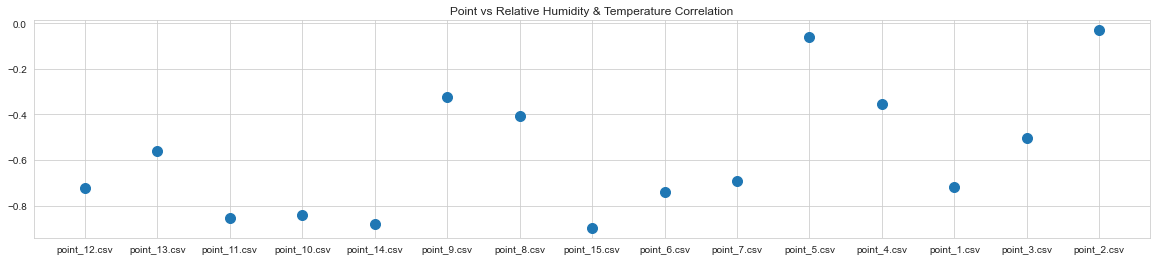

In [435]:
d2 = {'Point': points, 'Correlation': corrs}
df2 = pd.DataFrame(data=d2)
plt.figure(figsize=(100,100), dpi=80)
plt.figure(figsize=(20,4))
plt.scatter(df2['Point'],df2['Correlation'],alpha=1,s=100)
plt.title("Point vs Relative Humidity & Temperature Correlation")    
plt.show()

### Correlation Conclusion
We expect that if the temperature *increases*, relative humidity *decreases* so they are inversely proportional. 

Both `point2` and `point5` have weak negative correlation. They have almost positive correlation. 
\
Besides,`point15` and `point14` have strong negative correlation which proves our hypothesis. 

To make our hypothesis stronger, regression graphs are used in below. 

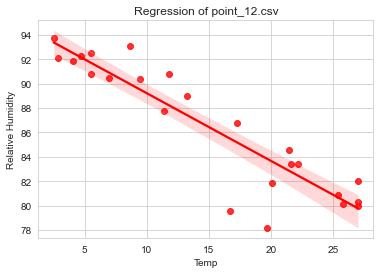

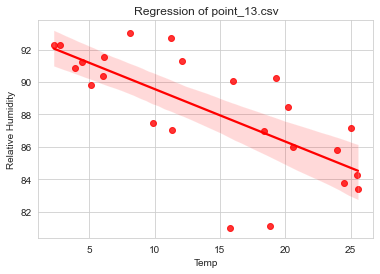

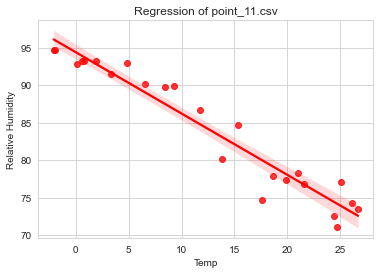

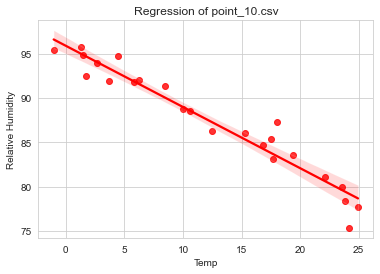

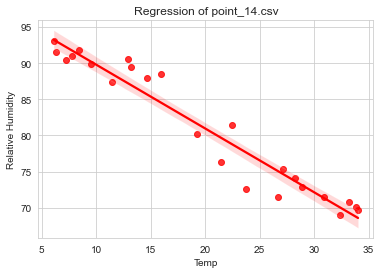

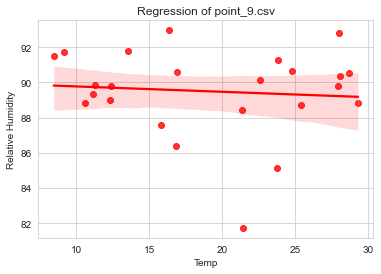

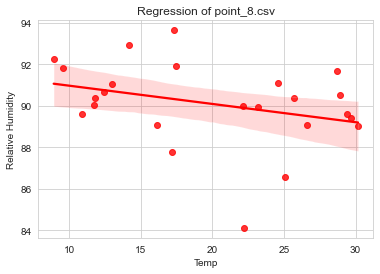

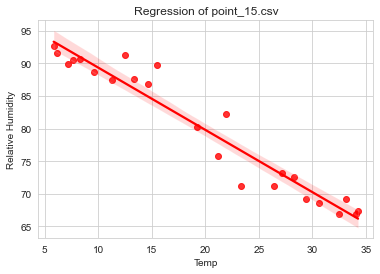

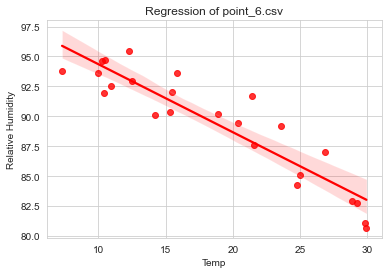

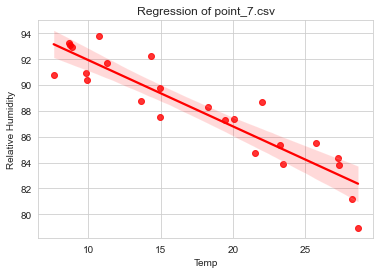

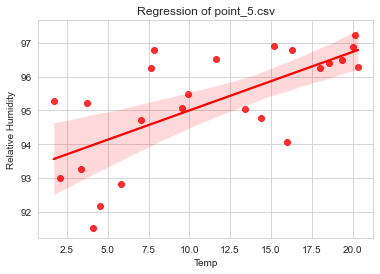

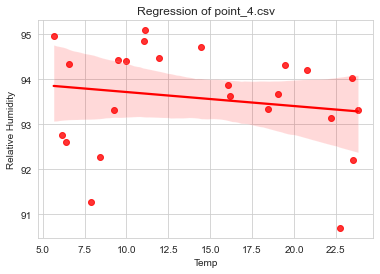

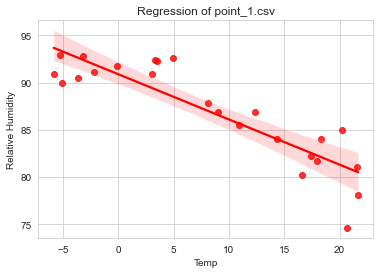

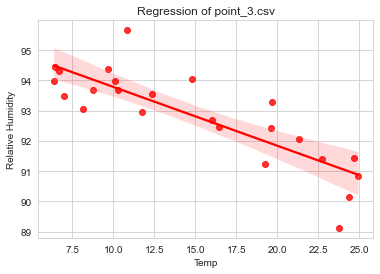

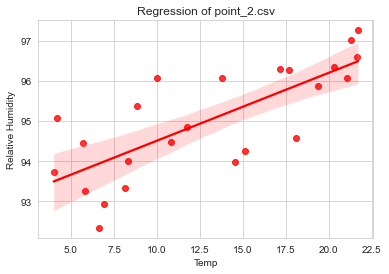

In [426]:
#calculate mean for temperature and humidity
mean_data = []
for el in dataframes_list:
    name, frame = findCSVName(el)
    reg = getRegression(frame, name)
    mean_data.append({name: getMean(frame)})

### Regression Conclusion
| Point         |Negative Correlation Type| 
| ------------- |:-------------:|
| Point1        | Moderately High | 
| Point2        | Negligible     | 
| Point3        | Moderate     |   
| Point4        | Low  | 
| Point5        | Negligible | 
| Point6        | Moderately High | 
| Point7        | Moderately High | 
| Point8        |  Moderate    | 
| Point9        |  Low     | 
| Point10       | High | 
| Point11       | High     | 
| Point12       | Moderately High    | 
| Point13       | Moderate | 
| Point14       | High      | 
| Point15       | High     | 

## Monthly Relative Humidity and Temperature Changes

In [427]:
#seperate temperature and relative humidity to plot monthly changes
temps = []
hums = []
for el in mean_data:
    name, frame = findCSVName(el)
    TEMP_DATA = frame.iloc[:,0]
    HUM_DATA = frame.iloc[:,1]
    temps.append({name: TEMP_DATA})
    hums.append({name: HUM_DATA})

### To more detailed exploratory analysis monthly temperature change is examined.

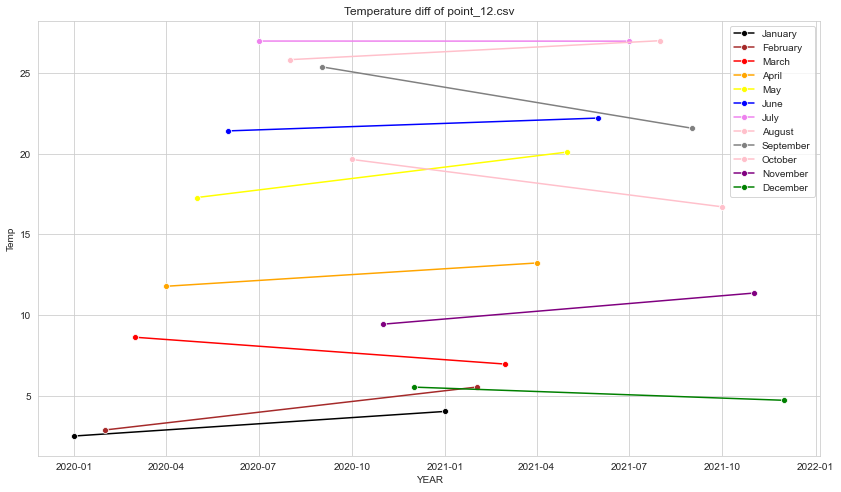

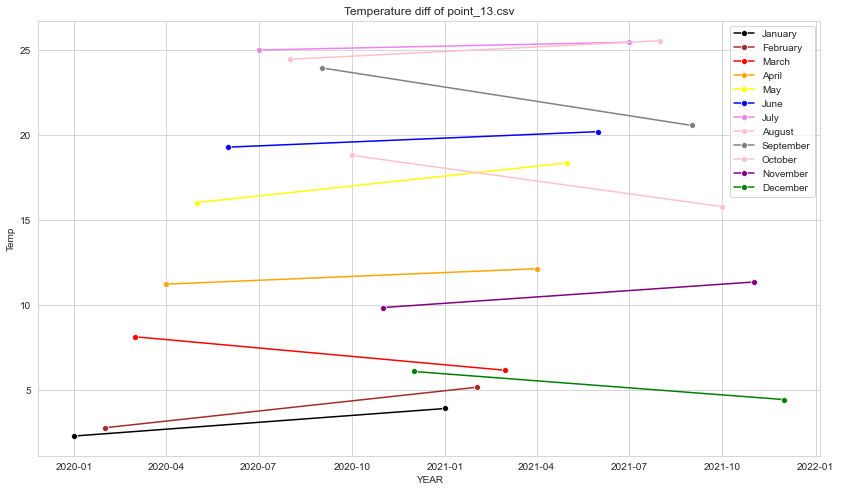

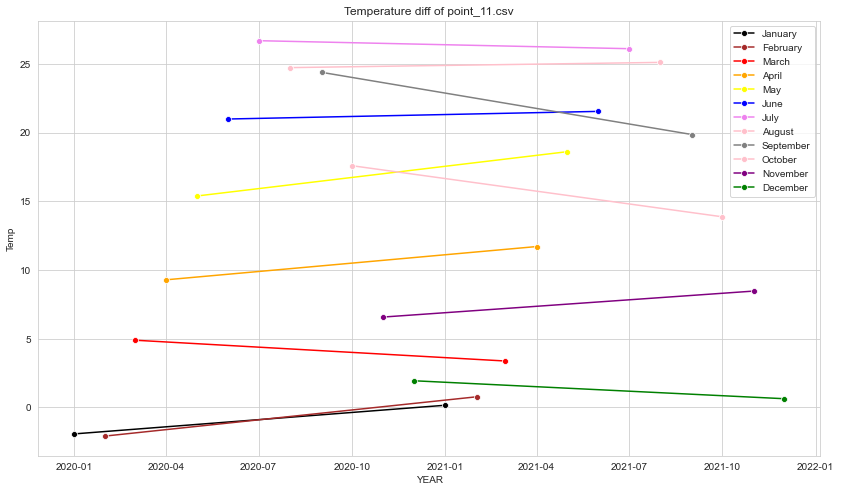

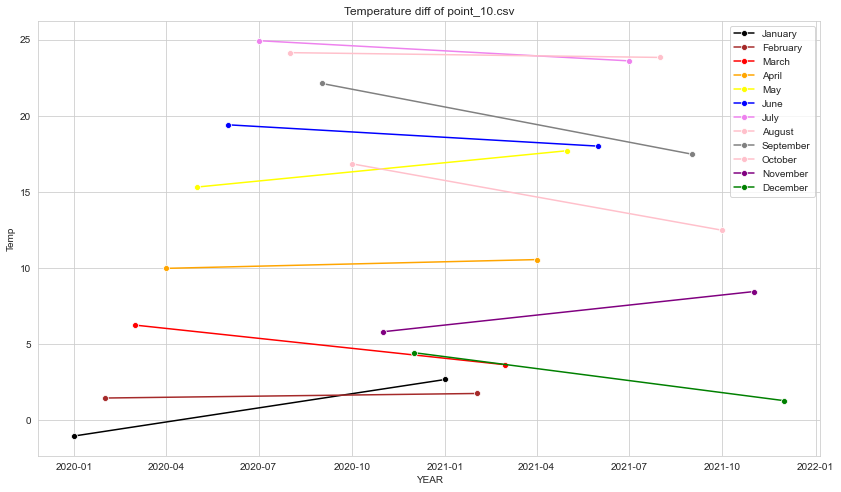

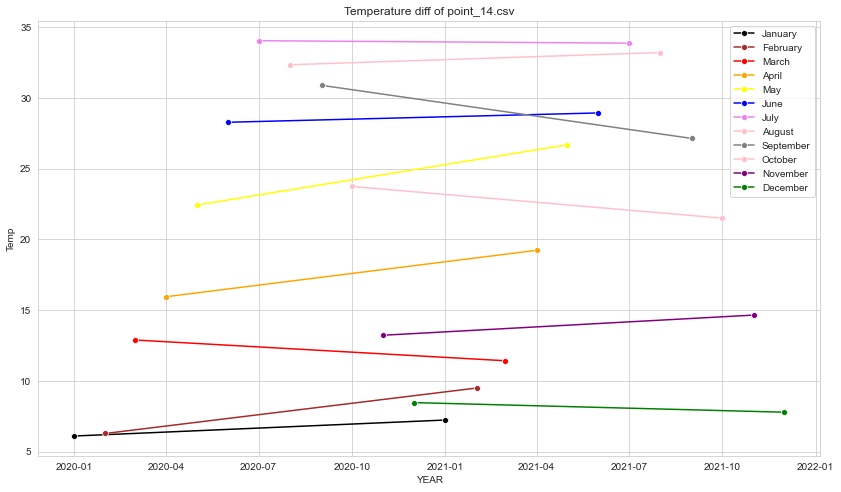

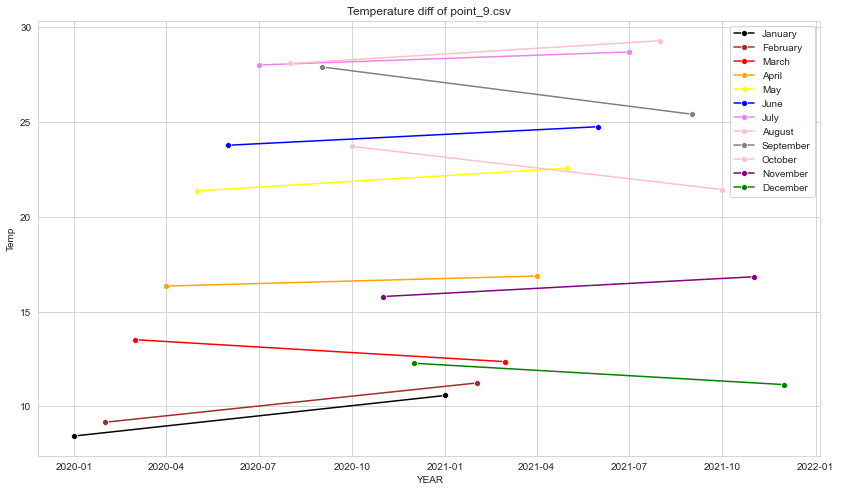

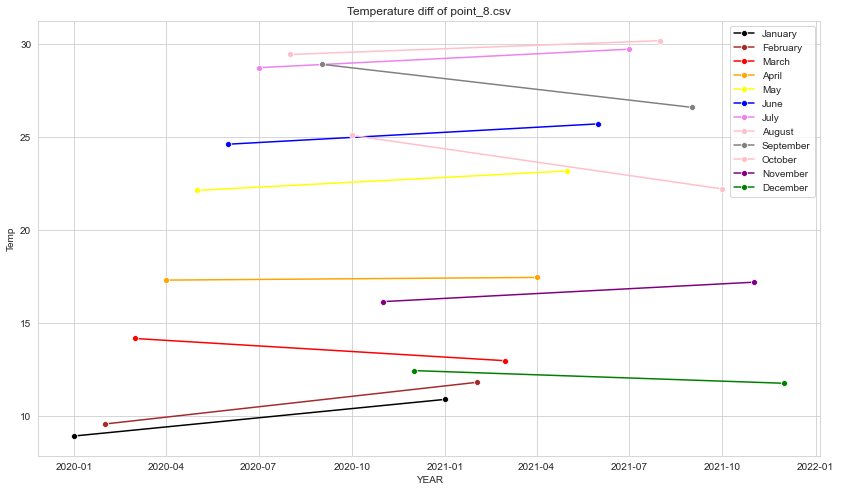

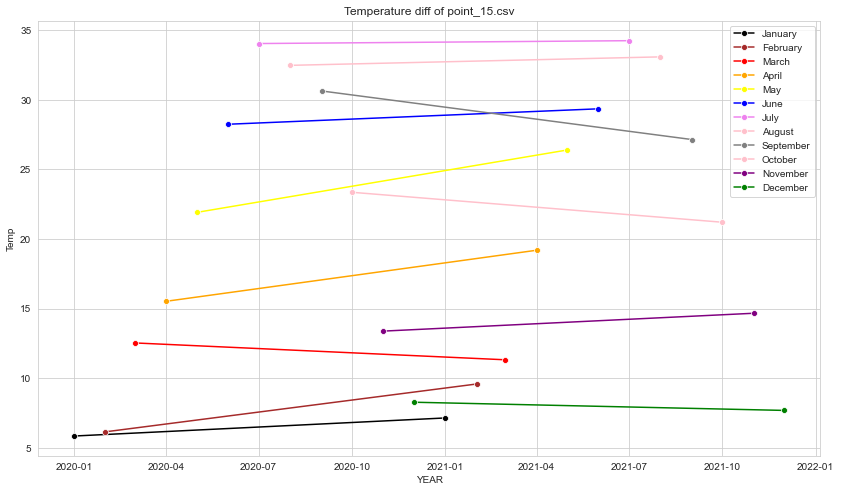

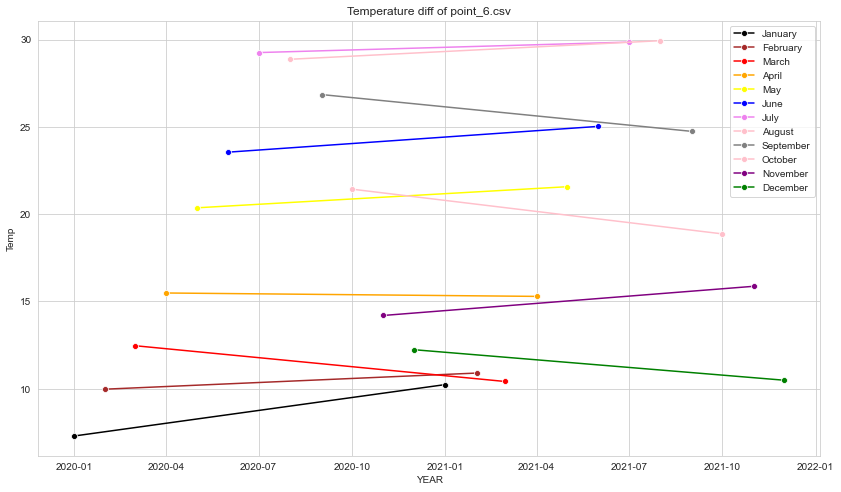

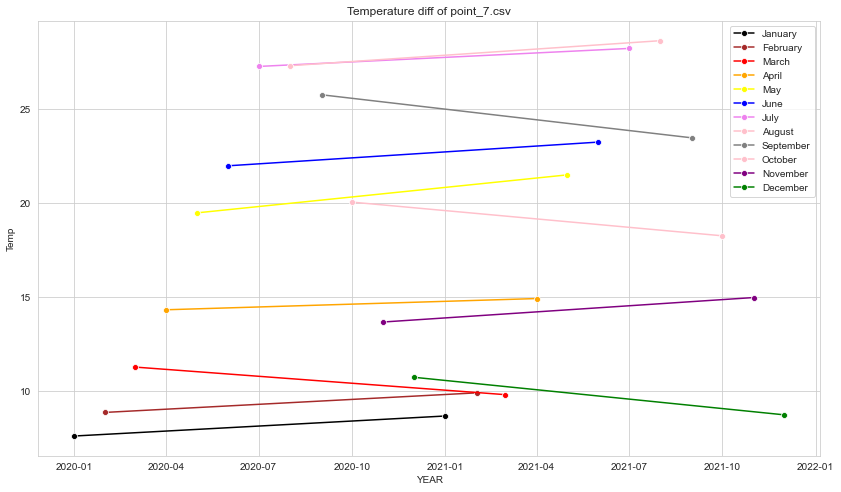

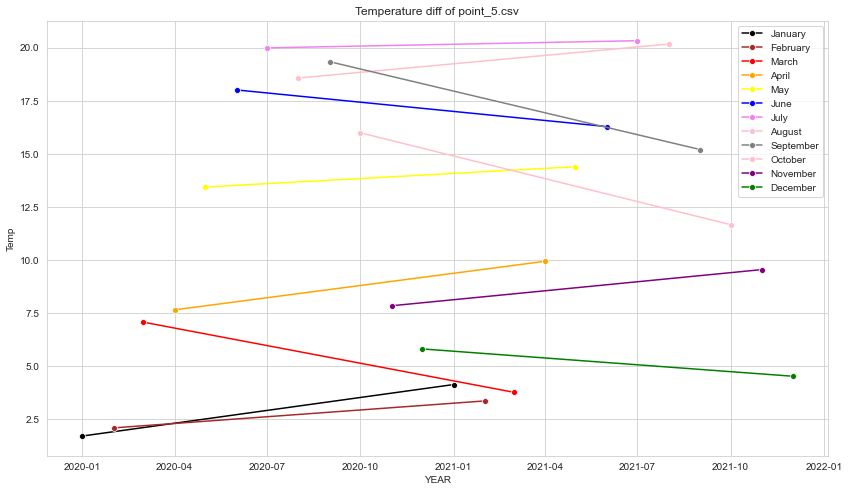

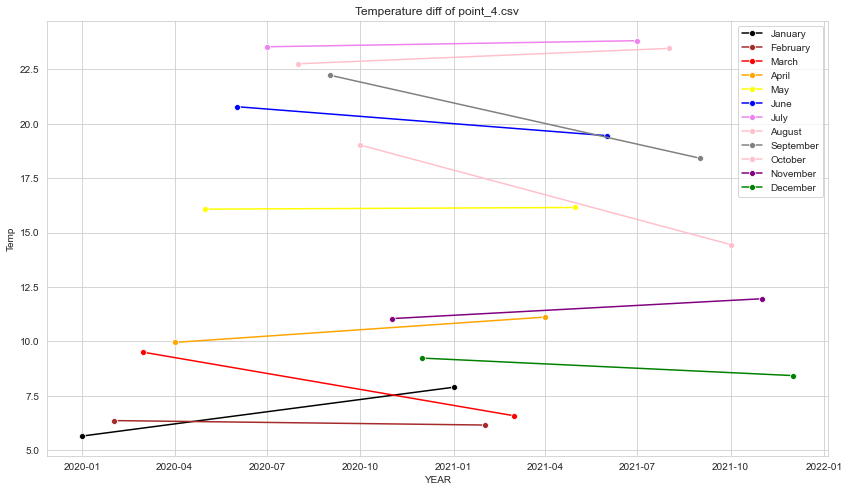

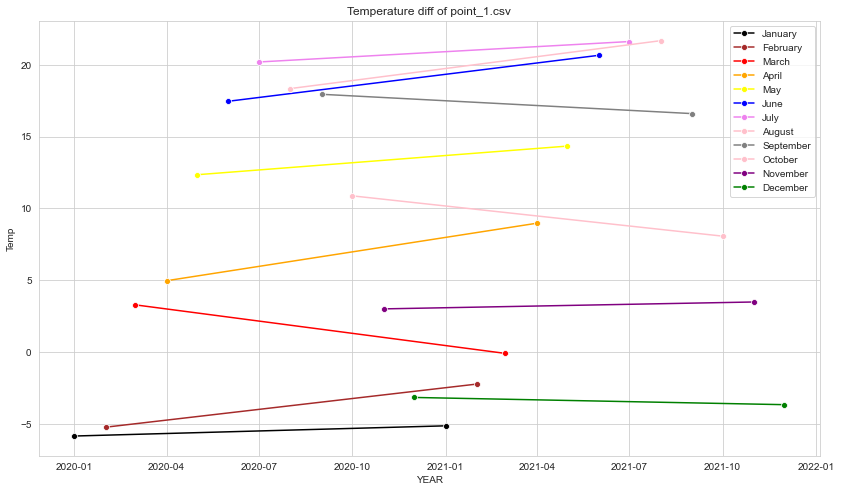

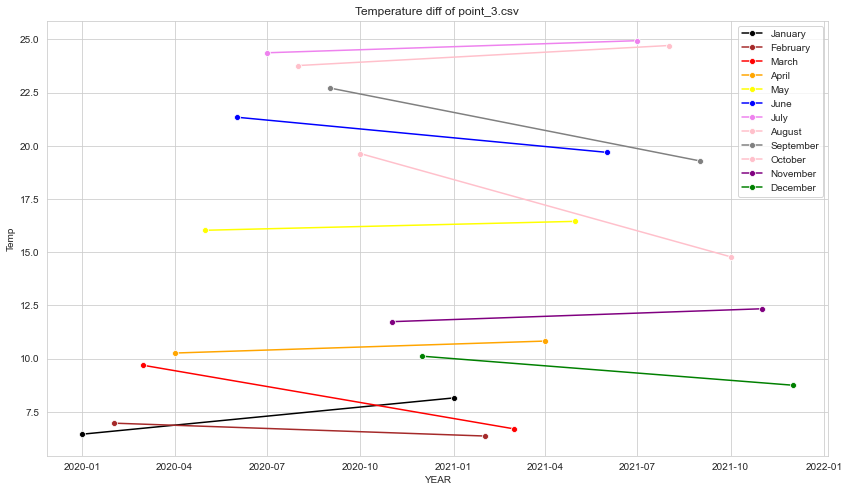

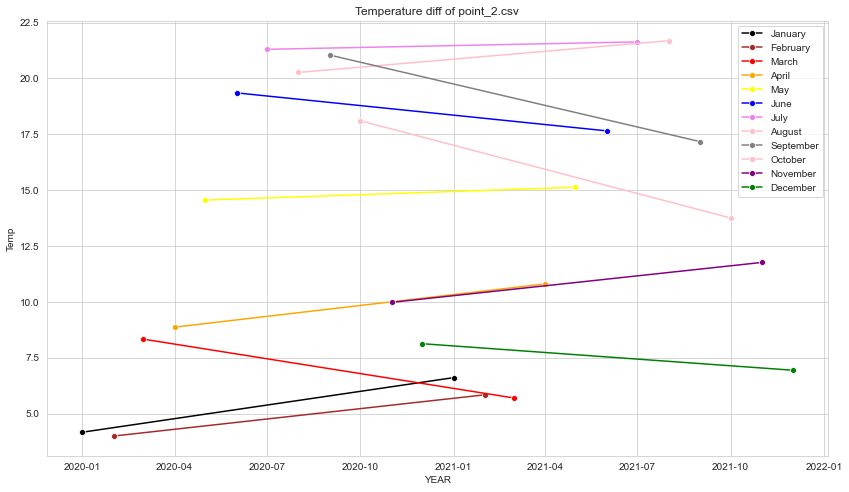

In [440]:
#plot monthly temperature
for el in temps:
    name, frame = findCSVName(el)
    sns_plot(name, frame, 'Temperature')

### To more detailed exploratory analysis monthly relative humidity change is examined.

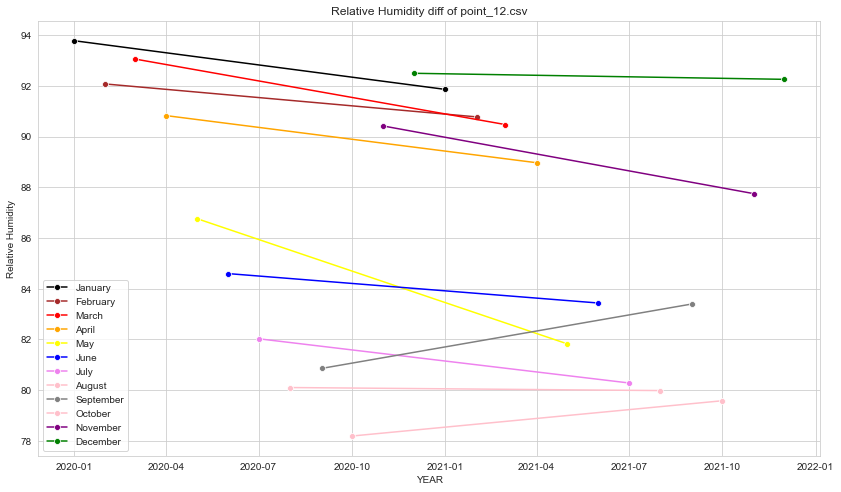

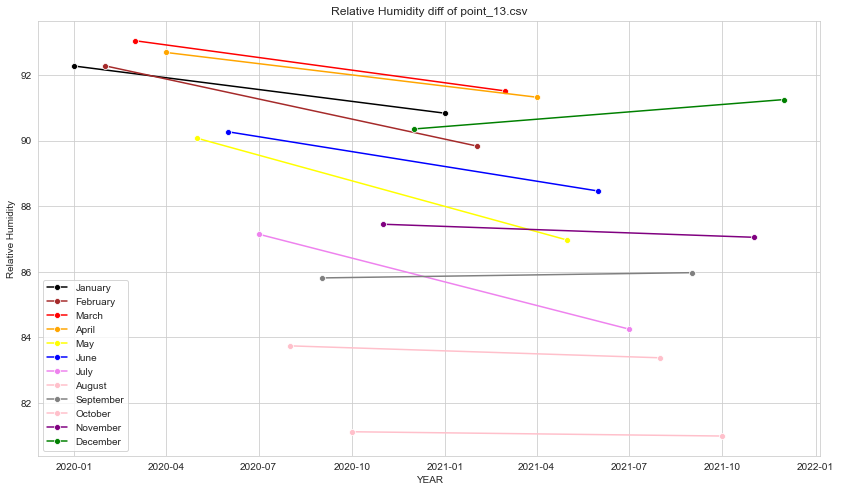

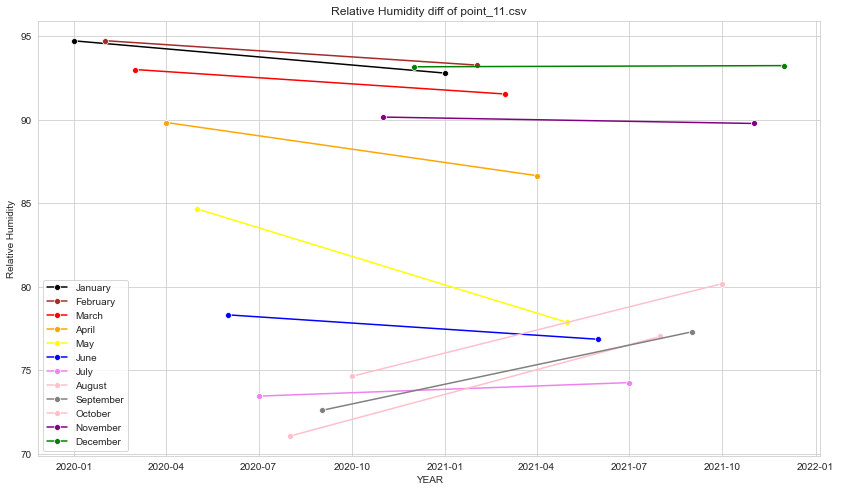

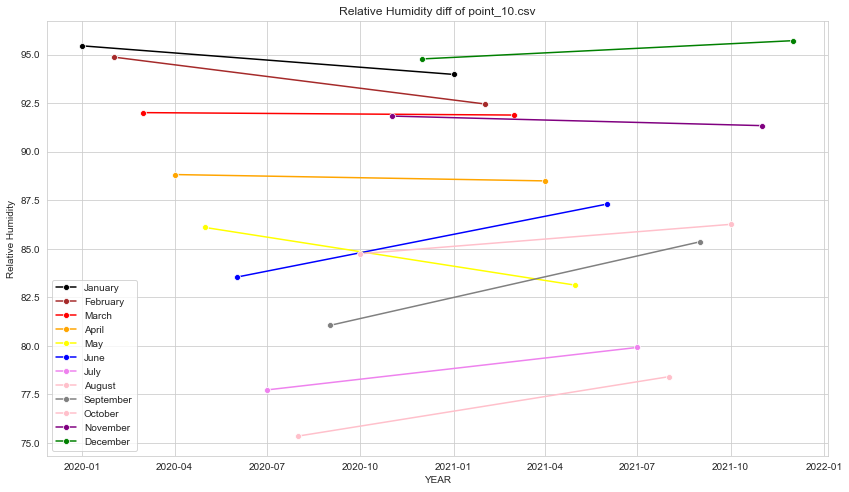

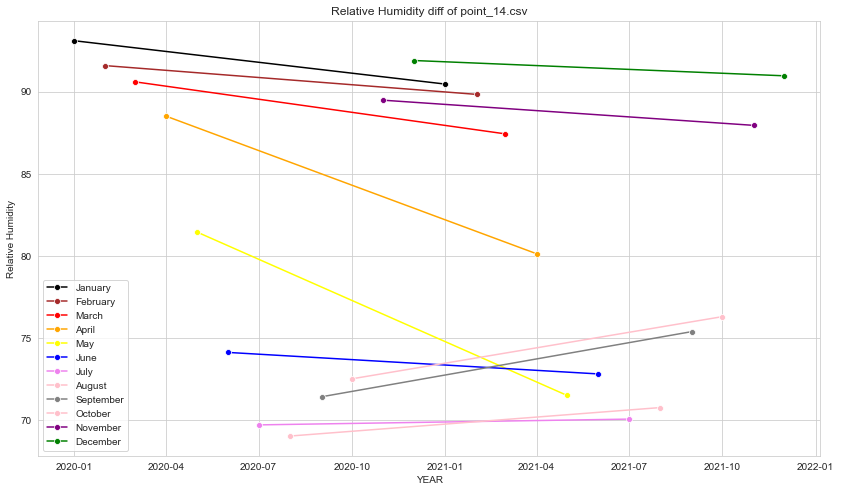

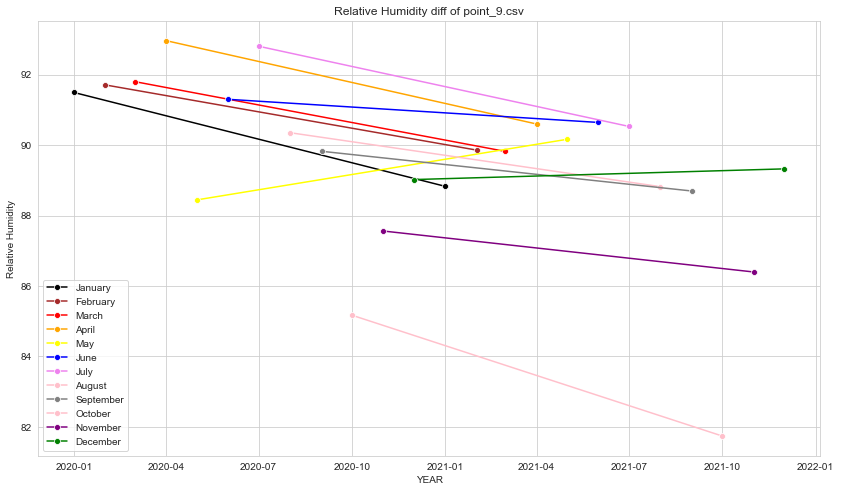

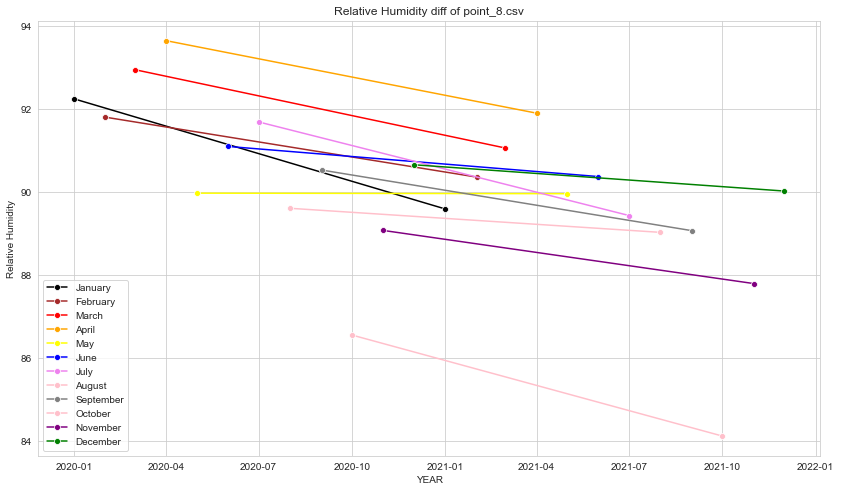

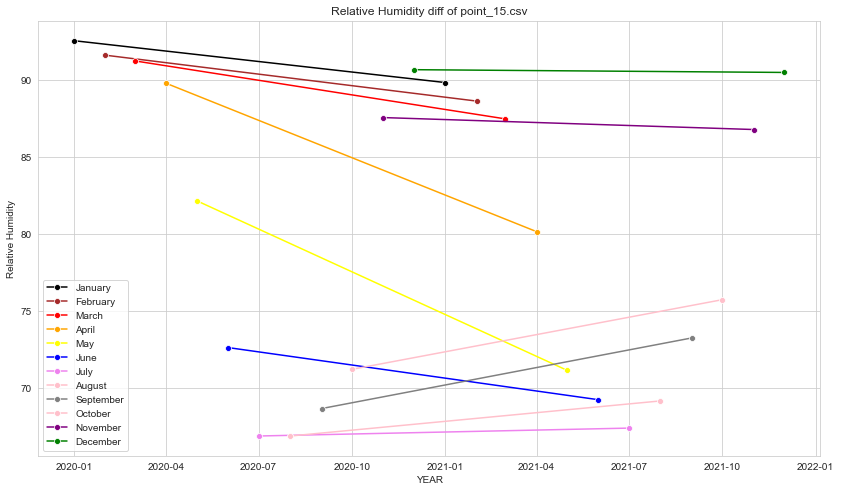

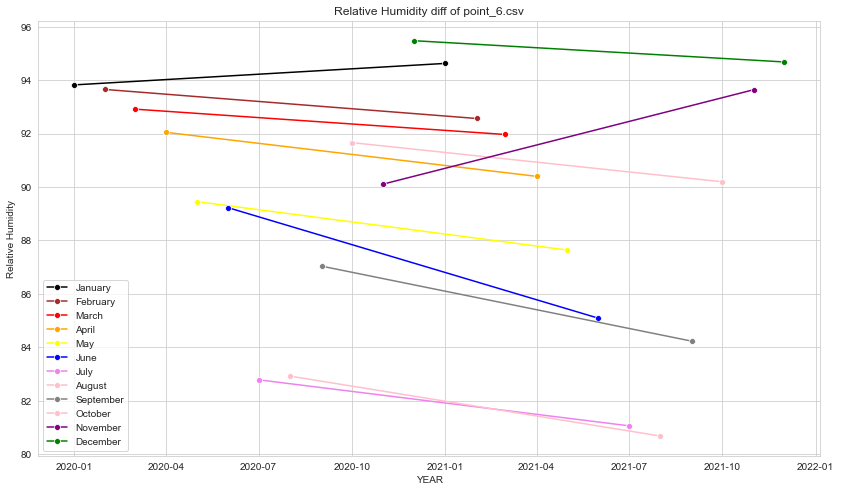

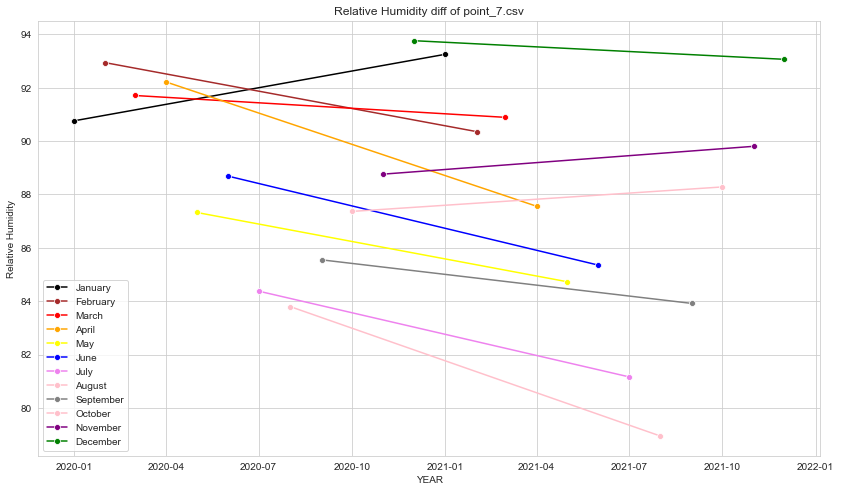

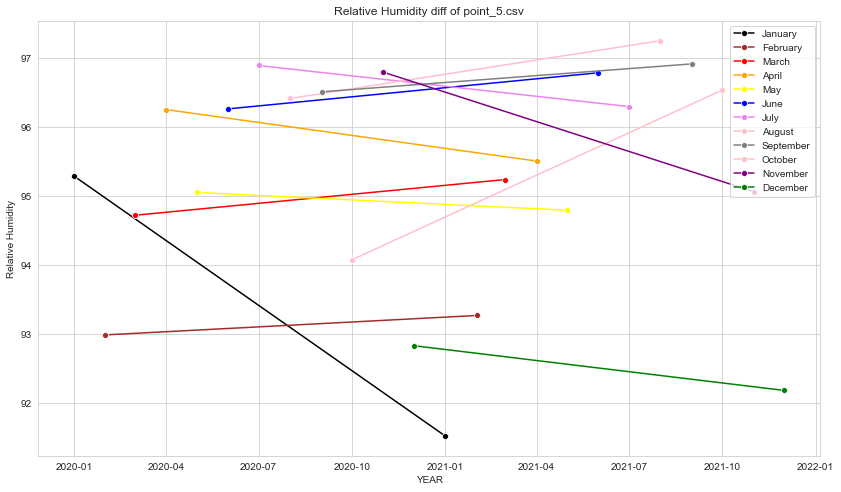

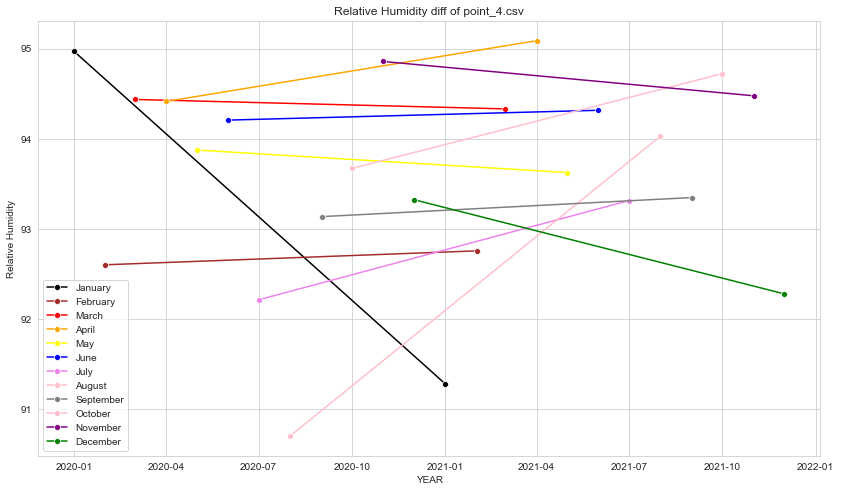

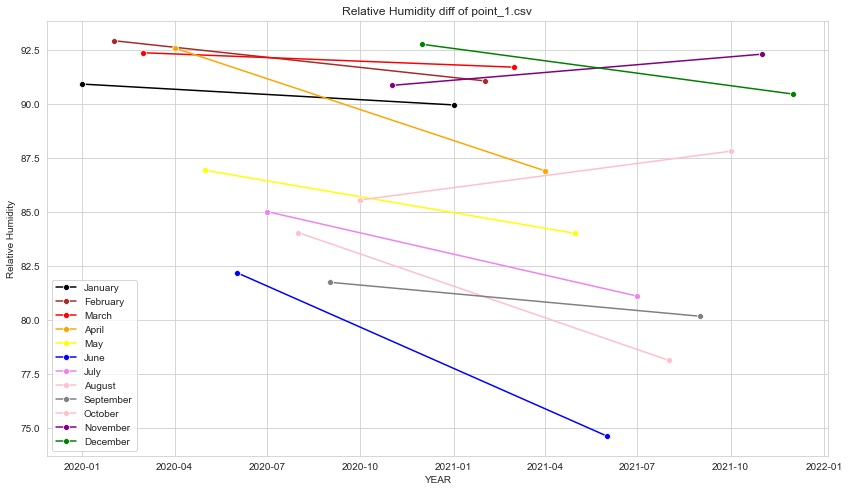

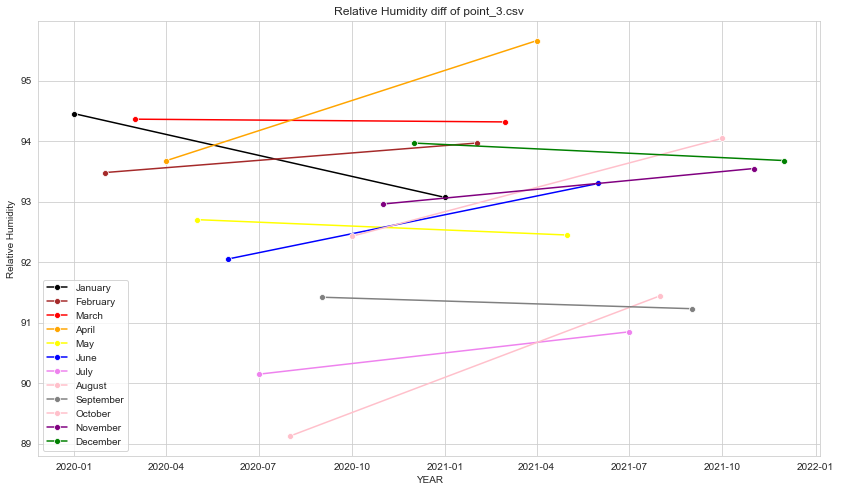

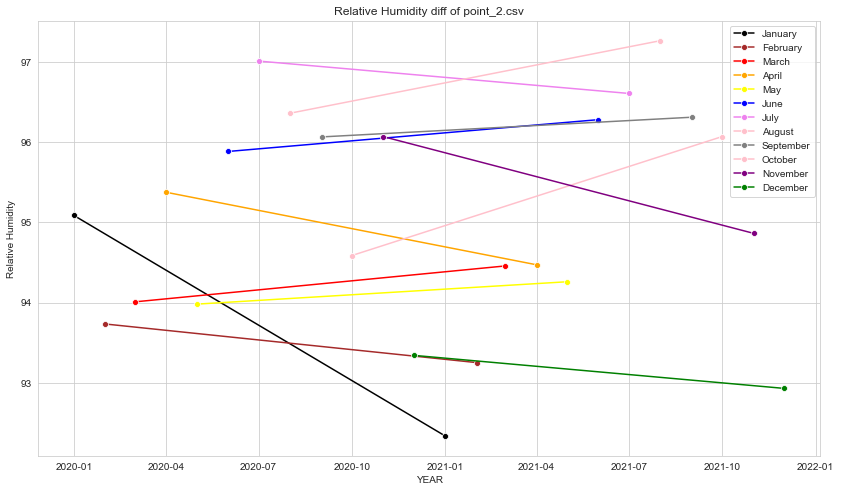

In [355]:
#plot monthly relative humidities
for el in hums:
    name, frame = findCSVName(el)
    sns_plot(name, frame, 'Relative Humidity')
    